<h1 style="color: white; background: #ADD8E6; text-align:center; font-size: 2.3em;"> MoA + Feature Engeneering + Keras </h1>

# Version Changes

### Version 4: Fine Tuned Params on TabNet. Changes: n_independent, n_shared, and momentum
### Version 5: Outputed CSV file for OOF preds, used to optimize blending weights
### Version 6: Added weighted blending, decreased the learning rate and changed the optimizer to AdaBelief
### Version 14: Added Information Gain for Feature Selection

## File Paths

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/test_features.csv
/kaggle/input/iterative-stratification/iterative-stratification-master/setup.py
/kaggle/input/iterative-stratification/iterative-stratification-master/.travis.yml
/kaggle/input/iterative-stratification/iterative-stratification-master/setup.cfg
/kaggle/input/iterative-stratification/iterative-stratification-master/.gitignore
/kaggle/input/iterative-stratification/iterative-stratification-master/LICENSE
/kaggle/input/iterative-stratification/iterative-stratification-master/README.md
/kaggle/input/iterative-stratification/iterative-stratification-master/iterstrat/__init__.py
/kaggle/input/iterative-stratification/iterative-stratification-master/iterstrat/ml_stratifiers.py
/kaggle/input/iterative-stratification/iterative-stratifi

# 1. Preparation

In [2]:
!pip uninstall -y typing
!pip install ../input/pytorchtabnetpretraining/pytorch_tabnet-2.0.1-py3-none-any.whl
!pip install /kaggle/input/iterative-stratification/iterative-stratification-master/

Found existing installation: typing 3.7.4.3
Uninstalling typing-3.7.4.3:
  Successfully uninstalled typing-3.7.4.3
Processing /kaggle/input/pytorchtabnetpretraining/pytorch_tabnet-2.0.1-py3-none-any.whl
Processing /kaggle/input/iterative-stratification/iterative-stratification-master
  Created wheel for iterative-stratification: filename=iterative_stratification-0.1.6-py3-none-any.whl size=8401 sha256=44b5a6a8a87f67724de067565038068842946b36c995f08d592e9e9499c2afd5
  Stored in directory: /root/.cache/pip/wheels/b8/47/3f/eb4af42d124f37d23d6f13a4c8bbc32c1d70140e6e1cecb4aa
Successfully built iterative-stratification


## 1.1 Imports

In [3]:
import numpy as np
import pandas as pd

## Keras and Tf ##

import tensorflow as tf
import tensorflow.keras.callbacks as C
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.optimizers as O
import tensorflow.keras.utils as U
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback

#Utils

import random
import os
import math
import tqdm

## Preprocessing and sklearn ##

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD, IncrementalPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from skmultilearn.problem_transform import LabelPowerset
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
sys.path.append('../input/rank-gauss')
from gauss_rank_scaler import GaussRankScaler

## Pytorch ##

import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.optimizer import Optimizer

## TabNet
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


## 1.2 Reading Files

In [4]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sub = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [5]:
train_features

sig_id      cp_type  cp_time cp_dose     g-0     g-1     g-2  \
0      id_000644bb2       trt_cp       24      D1  1.0620  0.5577 -0.2479   
1      id_000779bfc       trt_cp       72      D1  0.0743  0.4087  0.2991   
2      id_000a6266a       trt_cp       48      D1  0.6280  0.5817  1.5540   
3      id_0015fd391       trt_cp       48      D1 -0.5138 -0.2491 -0.2656   
4      id_001626bd3       trt_cp       72      D2 -0.3254 -0.4009  0.9700   
...             ...          ...      ...     ...     ...     ...     ...   
23809  id_fffb1ceed       trt_cp       24      D2  0.1394 -0.0636 -0.1112   
23810  id_fffb70c0c       trt_cp       24      D2 -1.3260  0.3478 -0.3743   
23811  id_fffc1c3f4  ctl_vehicle       48      D2  0.3942  0.3756  0.3109   
23812  id_fffcb9e7c       trt_cp       24      D1  0.6660  0.2324  0.4392   
23813  id_ffffdd77b       trt_cp       72      D1 -0.8598  1.0240 -0.1361   

          g-3     g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94  \
0     -0.6208 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912   
1      0.0604  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957   
2     -0.0764 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240   
3      0.5288  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632   
4      0.6919  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
23809 -0.5080 -0.4713  0.7201  ...  0.1969  0.0262 -0.8121  0.3434  0.5372   
23810  0.9905 -0.7178  0.6621  ...  0.4286  0.4426  0.0423 -0.3195 -0.8086   
23811 -0.7389  0.5505 -0.0159  ...  0.5409  0.3755  0.7343  0.2807  0.4116   
23812  0.2044  0.8531 -0.0343  ... -0.1105  0.4258 -0.2012  0.1506  1.5230   
23813  0.7952 -0.3611 -3.6750  ... -3.3890 -1.7450 -6.6300 -4.0950 -7.3860   

         c-95    c-96    c-97    c-98    c-99  
0      0.6584 -0.3981  0.2139  0.3801  0.4176  
1      0.4899  0.1522  0.1241  0.6077  0.7371  
2     -0.3174 -0.6417 -0.2187 -1.4080  0.6931  
3     -1.2880 -1.6210 -0.8784 -0.3876 -0.8154  
4     -0.3031  0.1094  0.2885 -0.3786  0.7125  
...       ...     ...     ...     ...     ...  
23809 -0.3246  0.0631  0.9171  0.5258  0.4680  
23810 -0.9798 -0.2084 -0.1224 -0.2715  0.3689  
23811  0.6422  0.2256  0.7592  0.6656  0.3808  
23812  0.7101  0.1732  0.7015 -0.6290  0.0740  
23813 -1.4160 -3.5770 -0.4775 -2.1500 -4.2520  

[23814 rows x 876 columns]

In [6]:
target_cols = sub.columns[1:]

## 1.3 Set Seed for Reproducibility

In [7]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# 2. Feature Engineering/Selection

## 2.1 Remove Control Group

In [8]:
# Remove control group
train_features = train_features[train_features["cp_type"] != "ctl_vehicle"]
test_features = test_features[test_features["cp_type"] != "ctl_vehicle"]
train_targets = train_targets.iloc[train_features.index]
train_features.reset_index(drop = True, inplace = True)
test_features.reset_index(drop = True, inplace = True)
train_targets.reset_index(drop = True, inplace = True)

## 2.2 Information Gain

In [9]:
cols_numeric = [feat for feat in list(train_features.columns) if feat not in ['sig_id', 'cp_type', 'cp_time', 'cp_dose']]

In [10]:
# lp = LabelPowerset()
# train_tar_lp = lp.transform(train_targets[target_cols])
# features = mutual_info_classif(train_features[cols_numeric].values, train_tar_lp)
# info_gain = dict(zip(cols_numeric, features))

In [11]:
info_gain = {'g-0': 0.16536566375573258, 'g-1': 0.03238642542722747, 'g-2': 0.02038068618937583, 'g-3': 0.09527671795569503, 'g-4': 0.07908530616603926, 'g-5': 0.025348972481901377, 'g-6': 0.05355601095899942, 'g-7': 0.14184118591618233, 'g-8': 0.2138847416035512, 'g-9': 0.10435325296164777, 'g-10': 0.15602108443308182, 'g-11': 0.07289685258891243, 'g-12': 0.11427909947471626, 'g-13': 0.1272941810593835, 'g-14': 0.09944541695424114, 'g-15': 0.04565967743223798, 'g-16': 0.1423456298264707, 'g-17': 0.12501647940795113, 'g-18': 0.07056301705786971, 'g-19': 0.04457810683971175, 'g-20': 0.18965887722988128, 'g-21': 0.06803247770675114, 'g-22': 0.1423287358038383, 'g-23': 0.060946006671929176, 'g-24': 0.107982656140031, 'g-25': 0.057650690164224194, 'g-26': 0.1238766487769638, 'g-27': 0.07199177266490153, 'g-28': 0.18687461407960626, 'g-29': 0.18120797110720677, 'g-30': 0.1819113316806975, 'g-31': 0.12417511142018345, 'g-32': 0.06884918035581222, 'g-33': 0.12378293326472001, 'g-34': 0.1327596761741976, 'g-35': 0.09950184615992708, 'g-36': 0.14125436564072924, 'g-37': 0.22127673820556293, 'g-38': 0.18872903625916138, 'g-39': 0.15238733874743193, 'g-40': 0.09793923435719787, 'g-41': 0.15685747585461485, 'g-42': 0.0660507388649707, 'g-43': 0.06050097693879941, 'g-44': 0.04270060533217279, 'g-45': 0.04177206803184408, 'g-46': 0.1253773187563123, 'g-47': 0.1502539563307037, 'g-48': 0.1576052645679109, 'g-49': 0.09081220100940346, 'g-50': 0.2304596074774965, 'g-51': 0.1275915531311833, 'g-52': 0.1520840633257441, 'g-53': 0.10065606722198073, 'g-54': 0.0679819420681822, 'g-55': 0.12531786342364892, 'g-56': 0.011558717321303646, 'g-57': 0.13309120127911633, 'g-58': 0.18425530697781678, 'g-59': 0.14765066302603813, 'g-60': 0.12175286400516683, 'g-61': 0.09930138628993834, 'g-62': 0.22142979647525518, 'g-63': 0.237288235961981, 'g-64': 0.07776849312408274, 'g-65': 0.1147765176905704, 'g-66': 0.13709758060749877, 'g-67': 0.14529817107071974, 'g-68': 0.17243748600696662, 'g-69': 0.06848208725586336, 'g-70': 0.13510554334285363, 'g-71': 0.053446647803481184, 'g-72': 0.19955924356595567, 'g-73': 0.07571375289977311, 'g-74': 0.11572783237363726, 'g-75': 0.3080205427081655, 'g-76': 0.05112910015115979, 'g-77': 0.04265682396133208, 'g-78': 0.0890439760639179, 'g-79': 0.1251680804942179, 'g-80': 0.09755163779536868, 'g-81': 0.10558849665722292, 'g-82': 0.028854833896020615, 'g-83': 0.1552905730272034, 'g-84': 0.1042158283409762, 'g-85': 0.1637057480340074, 'g-86': 0.13139133174824025, 'g-87': 0.09481537139826646, 'g-88': 0.08238744736747527, 'g-89': 0.09203536208879903, 'g-90': 0.13789428345059918, 'g-91': 0.23857292815517894, 'g-92': 0.1394837841813965, 'g-93': 0.08361404533625372, 'g-94': 0.10781069803060728, 'g-95': 0.1520414429166097, 'g-96': 0.16454480849009379, 'g-97': 0.1494572836772381, 'g-98': 0.16363620826016056, 'g-99': 0.11797143594701875, 'g-100': 0.2571539741904383, 'g-101': 0.03569610096287601, 'g-102': 0.20663306612790233, 'g-103': 0.09201033175821571, 'g-104': 0.03943936199092324, 'g-105': 0.1091660636965397, 'g-106': 0.16030300546952514, 'g-107': 0.1561113639018048, 'g-108': 0.07973785141838885, 'g-109': 0.1042395724785905, 'g-110': 0.08732221728318201, 'g-111': 0.08621140710657649, 'g-112': 0.12567929952601453, 'g-113': 0.1643520565412926, 'g-114': 0.13011837306610907, 'g-115': 0.05550823686001927, 'g-116': 0.10933324665341715, 'g-117': 0.16375191395924027, 'g-118': 0.10133622474899706, 'g-119': 0.0979350676391535, 'g-120': 0.05706711033305911, 'g-121': 0.20020434177631952, 'g-122': 0.11146247778987739, 'g-123': 0.17310287760109588, 'g-124': 0.07795218506830182, 'g-125': 0.08021665585772375, 'g-126': 0.13837978121167271, 'g-127': 0.054401691396393836, 'g-128': 0.19139386995875718, 'g-129': 0.07973388139019466, 'g-130': 0.08245600074046422, 'g-131': 0.19572993225039514, 'g-132': 0.1386884128217396, 'g-133': 0.16942071958720284, 'g-134': 0.17115045650048977, 'g-135': 0.1473298451760474, 'g-136': 0.13262521107136038, 'g-137': 0.1440466743263471, 'g-138': 0.13021515511668103, 'g-139': 0.1659799266692339, 'g-140': 0.1919116164222885, 'g-141': 0.06546812642130995, 'g-142': 0.175233703493074, 'g-143': 0.08328885695295707, 'g-144': 0.17058855094274072, 'g-145': 0.10103414632419572, 'g-146': 0.1684088496538454, 'g-147': 0.18708743494735192, 'g-148': 0.16565140139458556, 'g-149': 0.07504781840726782, 'g-150': 0.0680140421870794, 'g-151': 0.03343460572320289, 'g-152': 0.18329595445065916, 'g-153': 0.0555603503067692, 'g-154': 0.05614498394639256, 'g-155': 0.15838633604114705, 'g-156': 0.1395705539052461, 'g-157': 0.14958582685807542, 'g-158': 0.19566250883497105, 'g-159': 0.036545991906004716, 'g-160': 0.1518685974472671, 'g-161': 0.014069788492908408, 'g-162': 0.10251692777304733, 'g-163': 0.18359422784542367, 'g-164': 0.15929871720608269, 'g-165': 0.09760471807395277, 'g-166': 0.14074835729796842, 'g-167': 0.14103988270997547, 'g-168': 0.14150336173057276, 'g-169': 0.12545010407586332, 'g-170': 0.15280099596582275, 'g-171': 0.05795768115607203, 'g-172': 0.077509780759768, 'g-173': 0.16048599457395074, 'g-174': 0.08530790855275772, 'g-175': 0.24391131664825316, 'g-176': 0.08864313908073473, 'g-177': 0.11407331359821704, 'g-178': 0.19582368893908697, 'g-179': 0.06927149322784132, 'g-180': 0.08792397205796298, 'g-181': 0.2187322627000814, 'g-182': 0.06395574587205477, 'g-183': 0.19469586451910104, 'g-184': 0.05350363911045619, 'g-185': 0.18571739781990892, 'g-186': 0.1949491290949652, 'g-187': 0.1059197979748685, 'g-188': 0.06110808341351248, 'g-189': 0.1978492455341252, 'g-190': 0.08782281846713236, 'g-191': 0.0728362779735523, 'g-192': 0.12692928278274174, 'g-193': 0.06135472862879521, 'g-194': 0.13259764151225273, 'g-195': 0.22708187366528243, 'g-196': 0.1103036071445418, 'g-197': 0.11311139374185775, 'g-198': 0.0864860609028355, 'g-199': 0.1382055005998568, 'g-200': 0.09485033125301534, 'g-201': 0.20687054714330078, 'g-202': 0.18493505906831853, 'g-203': 0.23054039682447236, 'g-204': 0.07289169149519825, 'g-205': 0.03106952567131227, 'g-206': 0.20664576521315858, 'g-207': 0.1770633504545458, 'g-208': 0.2108786683919881, 'g-209': 0.06486479481988106, 'g-210': 0.163918637609898, 'g-211': 0.07695955973083901, 'g-212': 0.07256243540321972, 'g-213': 0.13755274094610215, 'g-214': 0.10948423410266361, 'g-215': 0.19403398425950158, 'g-216': 0.06211230679298918, 'g-217': 0.09603730034449676, 'g-218': 0.14648409140306828, 'g-219': 0.02725293531087125, 'g-220': 0.12939973368236668, 'g-221': 0.1632630068243177, 'g-222': 0.11425592749312496, 'g-223': 0.09361175635949603, 'g-224': 0.0659552041427478, 'g-225': 0.0847219177210441, 'g-226': 0.15872417022928786, 'g-227': 0.058925249013953795, 'g-228': 0.2215931715877817, 'g-229': 0.1621550760135797, 'g-230': 0.08436324860358013, 'g-231': 0.2441432107158228, 'g-232': 0.09452167820518032, 'g-233': 0.10326535230906586, 'g-234': 0.06740914163089329, 'g-235': 0.16697381832975644, 'g-236': 0.08882905758956827, 'g-237': 0.09142220037790771, 'g-238': 0.11125064908650639, 'g-239': 0.03496816942869874, 'g-240': 0.0890883843402932, 'g-241': 0.1913713775323327, 'g-242': 0.12864078637083765, 'g-243': 0.17314180284166447, 'g-244': 0.10508112096771693, 'g-245': 0.13626163522510826, 'g-246': 0.0771452555257568, 'g-247': 0.01393513004108815, 'g-248': 0.1982748515802566, 'g-249': 0.09656700125872764, 'g-250': 0.12947277902741394, 'g-251': 0.13889829095462503, 'g-252': 0.11578922328376251, 'g-253': 0.12588885899715674, 'g-254': 0.1617289502127699, 'g-255': 0.11212269176736811, 'g-256': 0.07932384339664189, 'g-257': 0.20480449675300338, 'g-258': 0.08720703201703106, 'g-259': 0.12690150073772877, 'g-260': 0.10500051354505668, 'g-261': 0.17650648443701744, 'g-262': 0.06543662500195335, 'g-263': 0.0816121956057918, 'g-264': 0.09119920093656297, 'g-265': 0.10013641173941323, 'g-266': 0.14524890726063244, 'g-267': 0.03765148559059561, 'g-268': 0.07283243451916022, 'g-269': 0.11749663586305292, 'g-270': 0.17341298609150524, 'g-271': 0.14943815381128545, 'g-272': 0.18570410959097483, 'g-273': 0.07829173272490131, 'g-274': 0.06578543359290467, 'g-275': 0.11665698529098822, 'g-276': 0.027787631917153277, 'g-277': 0.08574989340883299, 'g-278': 0.10843728476999104, 'g-279': 0.10628297231968276, 'g-280': 0.14399388148604153, 'g-281': 0.061903009152420196, 'g-282': 0.15183646215293578, 'g-283': 0.09476177356410886, 'g-284': 0.08657326150131706, 'g-285': 0.09032470150799199, 'g-286': 0.02324496819406985, 'g-287': 0.13170984778790285, 'g-288': 0.14262580779434852, 'g-289': 0.15561000072216657, 'g-290': 0.10082141689049351, 'g-291': 0.1783406777393921, 'g-292': 0.0855391481986878, 'g-293': 0.14437076739548704, 'g-294': 0.17107547385279354, 'g-295': 0.06272958349379554, 'g-296': 0.13038758598450606, 'g-297': 0.1883130958070245, 'g-298': 0.14612321904950232, 'g-299': 0.08374233014465471, 'g-300': 0.24214451407347326, 'g-301': 0.10784711333563646, 'g-302': 0.03709780832121101, 'g-303': 0.06363805040376747, 'g-304': 0.15170127241229991, 'g-305': 0.07393329623970857, 'g-306': 0.11166320811029529, 'g-307': 0.07063842875556503, 'g-308': 0.1159735586759334, 'g-309': 0.16011735726524723, 'g-310': 0.08556160793783096, 'g-311': 0.1561486373199914, 'g-312': 0.08313372867655477, 'g-313': 0.07667378472715569, 'g-314': 0.14213388642839853, 'g-315': 0.11338165268354494, 'g-316': 0.16693484797475922, 'g-317': 0.12663045598070166, 'g-318': 0.0657802895647901, 'g-319': 0.10356565549011165, 'g-320': 0.1697202136677083, 'g-321': 0.1036031993028601, 'g-322': 0.17777414766998945, 'g-323': 0.05532896845371216, 'g-324': 0.07783253441644256, 'g-325': 0.07505688379151998, 'g-326': 0.0336625197468754, 'g-327': 0.14147047702493598, 'g-328': 0.17779264059472677, 'g-329': 0.18105903436328052, 'g-330': 0.1100287595495697, 'g-331': 0.08470328978657093, 'g-332': 0.1838010035605322, 'g-333': 0.09699442244273371, 'g-334': 0.16586487336961042, 'g-335': 0.16094329263717277, 'g-336': 0.09455197095588108, 'g-337': 0.12122465849335828, 'g-338': 0.1539152297697184, 'g-339': 0.12975940547198217, 'g-340': 0.04252667391279186, 'g-341': 0.05089773821011612, 'g-342': 0.11301490211244136, 'g-343': 0.055019621266022334, 'g-344': 0.11652599111175643, 'g-345': 0.07756527275212388, 'g-346': 0.059819775238661776, 'g-347': 0.09666167111163393, 'g-348': 0.09409943975215906, 'g-349': 0.20259603300824125, 'g-350': 0.15214898358676976, 'g-351': 0.17764102970080575, 'g-352': 0.06091417327468207, 'g-353': 0.1793638678301841, 'g-354': 0.12764386795055493, 'g-355': 0.13880986116700544, 'g-356': 0.12155959610650946, 'g-357': 0.17062377869126255, 'g-358': 0.03370574375941793, 'g-359': 0.14495313388206732, 'g-360': 0.14818545755118429, 'g-361': 0.11124990606961305, 'g-362': 0.03099228850638802, 'g-363': 0.09107112078418567, 'g-364': 0.15726629128906122, 'g-365': 0.1820362830235549, 'g-366': 0.15735110428514165, 'g-367': 0.15894312257640753, 'g-368': 0.17694205417721776, 'g-369': 0.23159691584248598, 'g-370': 0.029948590967862287, 'g-371': 0.08356817192975363, 'g-372': 0.1260640385295888, 'g-373': 0.09329350222080546, 'g-374': 0.17752531284909878, 'g-375': 0.07580588294357327, 'g-376': 0.008993371368714698, 'g-377': 0.11605744434152943, 'g-378': 0.05263161512947345, 'g-379': 0.22026240219950743, 'g-380': 0.04819413915986992, 'g-381': 0.07827286363260022, 'g-382': 0.05584397425320997, 'g-383': 0.0430748362152622, 'g-384': 0.07699746612133751, 'g-385': 0.24027527812692373, 'g-386': 0.2206232055728634, 'g-387': 0.12962878801392375, 'g-388': 0.10069917190348576, 'g-389': 0.09274248816353747, 'g-390': 0.12755844954743, 'g-391': 0.061891261234122474, 'g-392': 0.23409519975683946, 'g-393': 0.14755369119144035, 'g-394': 0.14365813899002955, 'g-395': 0.1562148825627787, 'g-396': 0.05229814112499298, 'g-397': 0.13104196650845523, 'g-398': 0.13204720827108574, 'g-399': 0.018563839679180738, 'g-400': 0.13395682504360362, 'g-401': 0.03629671534652701, 'g-402': 0.1314539029208719, 'g-403': 0.07243734422459713, 'g-404': 0.05210462927506754, 'g-405': 0.12338281814512442, 'g-406': 0.2032431381255826, 'g-407': 0.17903476513936312, 'g-408': 0.11887123997738147, 'g-409': 0.16192829950219245, 'g-410': 0.20019045120813317, 'g-411': 0.1920023695854738, 'g-412': 0.057411089453180075, 'g-413': 0.012679609570461103, 'g-414': 0.2009991756974303, 'g-415': 0.06489922692300354, 'g-416': 0.044269964294591624, 'g-417': 0.1847174135736509, 'g-418': 0.18275041780076418, 'g-419': 0.05453403587779615, 'g-420': 0.051855714047088775, 'g-421': 0.10887724130494192, 'g-422': 0.12803700548685626, 'g-423': 0.15099978931379887, 'g-424': 0.15024966224815817, 'g-425': 0.04661054758353167, 'g-426': 0.07559710898931726, 'g-427': 0.1570306454682422, 'g-428': 0.06266051893650904, 'g-429': 0.11346016078103283, 'g-430': 0.015876622619090064, 'g-431': 0.13703506253201603, 'g-432': 0.14754237526219782, 'g-433': 0.15763429010435992, 'g-434': 0.15254122647112567, 'g-435': 0.05438188380840181, 'g-436': 0.07761491544056032, 'g-437': 0.10708781487797214, 'g-438': 0.05349438005669693, 'g-439': 0.1859293878013606, 'g-440': 0.12252777743395793, 'g-441': 0.14398198072599389, 'g-442': 0.11245816912941109, 'g-443': 0.21672117506934097, 'g-444': 0.08110879712936114, 'g-445': 0.08670534626183812, 'g-446': 0.08620939416467888, 'g-447': 0.10104840365137324, 'g-448': 0.10311813806201364, 'g-449': 0.09461032175466677, 'g-450': 0.12153423363843974, 'g-451': 0.09087593470634214, 'g-452': 0.015073317906795225, 'g-453': 0.08160225966664125, 'g-454': 0.07597196292339703, 'g-455': 0.10427244358599985, 'g-456': 0.14303230318155258, 'g-457': 0.06248174865202749, 'g-458': 0.12012416702596695, 'g-459': 0.15387196819217763, 'g-460': 0.18809530444651834, 'g-461': 0.08274334717980558, 'g-462': 0.05092400432005917, 'g-463': 0.0703103068878379, 'g-464': 0.1669964484620392, 'g-465': 0.03143864282943376, 'g-466': 0.06758772573962091, 'g-467': 0.16501757160194952, 'g-468': 0.1308598159239569, 'g-469': 0.05739682206900465, 'g-470': 0.08335002328149699, 'g-471': 0.06988721930826891, 'g-472': 0.055020653871244996, 'g-473': 0.08083880678301814, 'g-474': 0.10863398930731716, 'g-475': 0.10295024090047811, 'g-476': 0.0701217072243514, 'g-477': 0.10426234313724692, 'g-478': 0.1621476756958442, 'g-479': 0.1114306515204806, 'g-480': 0.1421750311719645, 'g-481': 0.04306192216100424, 'g-482': 0.07628941450511029, 'g-483': 0.03616207563129681, 'g-484': 0.08788169364477838, 'g-485': 0.08426327605913642, 'g-486': 0.2047534164054179, 'g-487': 0.12975076973616861, 'g-488': 0.15968529247809826, 'g-489': 0.20341120876060526, 'g-490': 0.03653772756527385, 'g-491': 0.12326434568103917, 'g-492': 0.0940516643626026, 'g-493': 0.10163075975734426, 'g-494': 0.15322020308395068, 'g-495': 0.0839673955316913, 'g-496': 0.09998962980109738, 'g-497': 0.12110316831932355, 'g-498': 0.12663381028052445, 'g-499': 0.1286014217842828, 'g-500': 0.1803637620373717, 'g-501': 0.06892776852744387, 'g-502': 0.10030444040913267, 'g-503': 0.1680051768943871, 'g-504': 0.11587881992675975, 'g-505': 0.04880918241340826, 'g-506': 0.1980527455372849, 'g-507': 0.06804442732789795, 'g-508': 0.14475821184680449, 'g-509': 0.12098541461824741, 'g-510': 0.04773207590343542, 'g-511': 0.08540333006153844, 'g-512': 0.23397984428924534, 'g-513': 0.02989826565903364, 'g-514': 0.04579741461862685, 'g-515': 0.1023351437040434, 'g-516': 0.037135148638883564, 'g-517': 0.13309157702545882, 'g-518': 0.053777161885862235, 'g-519': 0.06516871719903872, 'g-520': 0.06326431080860129, 'g-521': 0.059292825683400885, 'g-522': 0.2297250548796237, 'g-523': 0.08725456167204992, 'g-524': 0.06747897621290555, 'g-525': 0.12963481358632656, 'g-526': 0.07192641185196003, 'g-527': 0.03568825570622458, 'g-528': 0.06875255271310543, 'g-529': 0.19106859928091868, 'g-530': 0.05661709249040037, 'g-531': 0.1327944268356651, 'g-532': 0.05623992659521715, 'g-533': 0.16086880242368196, 'g-534': 0.20839357936126568, 'g-535': 0.08744962715836113, 'g-536': 0.025815824175616342, 'g-537': 0.13170027321408195, 'g-538': 0.059523014418769726, 'g-539': 0.10357705228381597, 'g-540': 0.10517646162812966, 'g-541': 0.11241079120680553, 'g-542': 0.06332053680446759, 'g-543': 0.10839964709655447, 'g-544': 0.05979684401420826, 'g-545': 0.09286962967935519, 'g-546': 0.16507691012506864, 'g-547': 0.0994802540680606, 'g-548': 0.09561599324147974, 'g-549': 0.047462617154252484, 'g-550': 0.02597650448136868, 'g-551': 0.1029145805377425, 'g-552': 0.043915200805758836, 'g-553': 0.17191346691138953, 'g-554': 0.10355941698799587, 'g-555': 0.03983255950142084, 'g-556': 0.06710893358661174, 'g-557': 0.07932223918078929, 'g-558': 0.09280873089307828, 'g-559': 0.15023784535187712, 'g-560': 0.06117857211298183, 'g-561': 0.1744063778092988, 'g-562': 0.12716849101655558, 'g-563': 0.1517070621553671, 'g-564': 0.1106093524623839, 'g-565': 0.15465910907212965, 'g-566': 0.11002736457449469, 'g-567': 0.03851419193338135, 'g-568': 0.16400305068381105, 'g-569': 0.20882523165362343, 'g-570': 0.1493614465153268, 'g-571': 0.027498173767191325, 'g-572': 0.031821741938257375, 'g-573': 0.05410167883461092, 'g-574': 0.1283108265708517, 'g-575': 0.11440170869260236, 'g-576': 0.08156451070947845, 'g-577': 0.12144942109193213, 'g-578': 0.16922218847159787, 'g-579': 0.07594161530741239, 'g-580': 0.10262190510905089, 'g-581': 0.04390003475563997, 'g-582': 0.06740787919542335, 'g-583': 0.06238665089533324, 'g-584': 0.030614897374029226, 'g-585': 0.021797850386856332, 'g-586': 0.09377900563626973, 'g-587': 0.05814854082952259, 'g-588': 0.1105640690982641, 'g-589': 0.08252363968293253, 'g-590': 0.1730259991685319, 'g-591': 0.08326606723626906, 'g-592': 0.05625757273077259, 'g-593': 0.11123007136324858, 'g-594': 0.10720088068136224, 'g-595': 0.06818606491434931, 'g-596': 0.08497667010228138, 'g-597': 0.16350755568632813, 'g-598': 0.07795364964950746, 'g-599': 0.08127615681081402, 'g-600': 0.10902938692847375, 'g-601': 0.07694275574328291, 'g-602': 0.0982441757653092, 'g-603': 0.14375766832706738, 'g-604': 0.08936560007388472, 'g-605': 0.0322852130613267, 'g-606': 0.06218918131835505, 'g-607': 0.0909350924313852, 'g-608': 0.07343292929748291, 'g-609': 0.062479662020916926, 'g-610': 0.06363588349192373, 'g-611': 0.047178181533859664, 'g-612': 0.023267168625569212, 'g-613': 0.10313319622205519, 'g-614': 0.12795810200293278, 'g-615': 0.16455045895239362, 'g-616': 0.07416517398763744, 'g-617': 0.10901023878485283, 'g-618': 0.11666669422120801, 'g-619': 0.13633404262865945, 'g-620': 0.19087902796224832, 'g-621': 0.10094466266795266, 'g-622': 0.0765320189743699, 'g-623': 0.09271096752473174, 'g-624': 0.1181164000437196, 'g-625': 0.1769157356037283, 'g-626': 0.12862231332864127, 'g-627': 0.06900232959237229, 'g-628': 0.15972275633567357, 'g-629': 0.17896013863432714, 'g-630': 0.06771765883421477, 'g-631': 0.1076247494494611, 'g-632': 0.1725378561745723, 'g-633': 0.08517238438271058, 'g-634': 0.13497910993205942, 'g-635': 0.204635713205497, 'g-636': 0.13167101236288126, 'g-637': 0.035527525865052034, 'g-638': 0.12615721092177967, 'g-639': 0.147100452610748, 'g-640': 0.09390450458037503, 'g-641': 0.12935894818054283, 'g-642': 0.10511659088065706, 'g-643': 0.0658706795930426, 'g-644': 0.09267494222353267, 'g-645': 0.12217278848771684, 'g-646': 0.10535772263441068, 'g-647': 0.13630918445266893, 'g-648': 0.09425135891154213, 'g-649': 0.03146785914971417, 'g-650': 0.04236469809357413, 'g-651': 0.0544986455666967, 'g-652': 0.10761583560559274, 'g-653': 0.05510763130183616, 'g-654': 0.04979706702844222, 'g-655': 0.05217255106493468, 'g-656': 0.07769146467920418, 'g-657': 0.08341373454794976, 'g-658': 0.08310628771372297, 'g-659': 0.07743455909561625, 'g-660': 0.033539161000653905, 'g-661': 0.13629948584147034, 'g-662': 0.15581354594167962, 'g-663': 0.06789575093749889, 'g-664': 0.17884079825670973, 'g-665': 0.11189711314679673, 'g-666': 0.040976579078032316, 'g-667': 0.07830040349233158, 'g-668': 0.10142466648370085, 'g-669': 0.17780906386673578, 'g-670': 0.13655730761405227, 'g-671': 0.15824992382406577, 'g-672': 0.21517050892343637, 'g-673': 0.17397690837068946, 'g-674': 0.17046577436238586, 'g-675': 0.08592953679728765, 'g-676': 0.05342368869905556, 'g-677': 0.1368484611124785, 'g-678': 0.10058728242480708, 'g-679': 0.09655466841718763, 'g-680': 0.0871590694164448, 'g-681': 0.10880451676915293, 'g-682': 0.054912756640666416, 'g-683': 0.19680691416086393, 'g-684': 0.09433344047711145, 'g-685': 0.09681401238215503, 'g-686': 0.10288496255983137, 'g-687': 0.051627522758704636, 'g-688': 0.06404237960079939, 'g-689': 0.18254835691552262, 'g-690': 0.09987164565157602, 'g-691': 0.15241069382782868, 'g-692': 0.03666107445823119, 'g-693': 0.12110961475207382, 'g-694': 0.029479572336891913, 'g-695': 0.11474064549336038, 'g-696': 0.12760206318113632, 'g-697': 0.12392438286006513, 'g-698': 0.14536225758806687, 'g-699': 0.12059241047794522, 'g-700': 0.12256441762609604, 'g-701': 0.12844348511967407, 'g-702': 0.13182668199270697, 'g-703': 0.11636788281543531, 'g-704': 0.13627450281943343, 'g-705': 0.16042582230670543, 'g-706': 0.12355877506112556, 'g-707': 0.005250828712061839, 'g-708': 0.1476962169555769, 'g-709': 0.1315193685394922, 'g-710': 0.07873113265734144, 'g-711': 0.12531957350339518, 'g-712': 0.18164239474974764, 'g-713': 0.020945829252316805, 'g-714': 0.09105313107503044, 'g-715': 0.017050497015484112, 'g-716': 0.0858185178680797, 'g-717': 0.11091177515971484, 'g-718': 0.07670210348503481, 'g-719': 0.026892365100590787, 'g-720': 0.14806507163978555, 'g-721': 0.1176756027385526, 'g-722': 0.07622857050218013, 'g-723': 0.19233141492045114, 'g-724': 0.15858745842314015, 'g-725': 0.06180312174959557, 'g-726': 0.16289709156253984, 'g-727': 0.09747095326855515, 'g-728': 0.18058800390515106, 'g-729': 0.08015208590777867, 'g-730': 0.051235214453147826, 'g-731': 0.23347977934589892, 'g-732': 0.06622681144224174, 'g-733': 0.15597170791580517, 'g-734': 0.05527667568577943, 'g-735': 0.06662901859059023, 'g-736': 0.09967409924797277, 'g-737': 0.037295012018612184, 'g-738': 0.12693591149394745, 'g-739': 0.06392333201297085, 'g-740': 0.04511931985468198, 'g-741': 0.08791935702571685, 'g-742': 0.1289871148205206, 'g-743': 0.1701396084234048, 'g-744': 0.22952666970406987, 'g-745': 0.13788474509850346, 'g-746': 0.0875724389520256, 'g-747': 0.06098705126289783, 'g-748': 0.06070485532117864, 'g-749': 0.1061399869135986, 'g-750': 0.17684030894615876, 'g-751': 0.07053560046310103, 'g-752': 0.12093275685227312, 'g-753': 0.09610285560997234, 'g-754': 0.08696763444613431, 'g-755': 0.035676756832764944, 'g-756': 0.03826892918201885, 'g-757': 0.09974336659258132, 'g-758': 0.09305288330497685, 'g-759': 0.15746025261411667, 'g-760': 0.19253852943861371, 'g-761': 0.21226630948217018, 'g-762': 0.04151650675811247, 'g-763': 0.14158358270253846, 'g-764': 0.16858907371683696, 'g-765': 0.09731433103624099, 'g-766': 0.09401819632985653, 'g-767': 0.12508003572667192, 'g-768': 0.08858144397629264, 'g-769': 0.11883397742590862, 'g-770': 0.14902629641635023, 'g-771': 0.14596299230710752, 'c-0': 0.18027605556534265, 'c-1': 0.2356018806479323, 'c-2': 0.21680667868386028, 'c-3': 0.18256580192158012, 'c-4': 0.20546663049673253, 'c-5': 0.19462546449157347, 'c-6': 0.2395951437961683, 'c-7': 0.16279933943354763, 'c-8': 0.2017084760151615, 'c-9': 0.22136561156080958, 'c-10': 0.22023437696402048, 'c-11': 0.20242490043306827, 'c-12': 0.1951371134135398, 'c-13': 0.2135842936282195, 'c-14': 0.19567791564295423, 'c-15': 0.1936687427444994, 'c-16': 0.15079121830738007, 'c-17': 0.22198629540710524, 'c-18': 0.23061787335278439, 'c-19': 0.18394498882724175, 'c-20': 0.18256563144532034, 'c-21': 0.20573697529538215, 'c-22': 0.15911312130151956, 'c-23': 0.1969616252651747, 'c-24': 0.18862554469651283, 'c-25': 0.19176698635460188, 'c-26': 0.23219858063352472, 'c-27': 0.1917156531367299, 'c-28': 0.1913870736952239, 'c-29': 0.16996280220109483, 'c-30': 0.21567893166363294, 'c-31': 0.20665161877598326, 'c-32': 0.1748172106821677, 'c-33': 0.22639549613335586, 'c-34': 0.21934396725894434, 'c-35': 0.18943160769484813, 'c-36': 0.20592565875402258, 'c-37': 0.17436662726382846, 'c-38': 0.22454680323538412, 'c-39': 0.17961783646593954, 'c-40': 0.2086796727015301, 'c-41': 0.20191469458260425, 'c-42': 0.2128310209454174, 'c-43': 0.1872478030396545, 'c-44': 0.20543649087846916, 'c-45': 0.195111903273804, 'c-46': 0.17900712406022468, 'c-47': 0.1971538920508653, 'c-48': 0.2042483146491305, 'c-49': 0.19619747124953957, 'c-50': 0.1975665095600938, 'c-51': 0.19541774911824028, 'c-52': 0.2144165341141102, 'c-53': 0.1810688324124241, 'c-54': 0.20037174091619558, 'c-55': 0.19314233550351734, 'c-56': 0.1510265314004835, 'c-57': 0.19252155976062113, 'c-58': 0.16679476108353075, 'c-59': 0.20121804538778054, 'c-60': 0.21931490197246006, 'c-61': 0.16989877131280195, 'c-62': 0.21625712738249891, 'c-63': 0.20426474992140697, 'c-64': 0.19283014549030053, 'c-65': 0.26850593939912937, 'c-66': 0.22365319574079745, 'c-67': 0.21264618563131332, 'c-68': 0.18572882386857614, 'c-69': 0.1693502832497238, 'c-70': 0.24428114188586125, 'c-71': 0.1893334349313074, 'c-72': 0.18573086261002203, 'c-73': 0.20533317957050912, 'c-74': 0.16291454288408502, 'c-75': 0.19303823218427407, 'c-76': 0.2104696899002665, 'c-77': 0.1996032580043403, 'c-78': 0.19775175593178052, 'c-79': 0.20602899149870968, 'c-80': 0.18390715540246028, 'c-81': 0.2009569254673167, 'c-82': 0.20861584726838878, 'c-83': 0.21820864678344076, 'c-84': 0.1962352165769916, 'c-85': 0.19536057517695227, 'c-86': 0.18619946881396832, 'c-87': 0.16713788433835663, 'c-88': 0.1848939320430283, 'c-89': 0.16322023363102556, 'c-90': 0.20388892857888852, 'c-91': 0.18710772133713593, 'c-92': 0.20920530222044675, 'c-93': 0.20824215409484115, 'c-94': 0.20864842749842172, 'c-95': 0.17779565677586007, 'c-96': 0.20697027625998032, 'c-97': 0.18190898421144297, 'c-98': 0.2587361233185357, 'c-99': 0.15206802991683777}

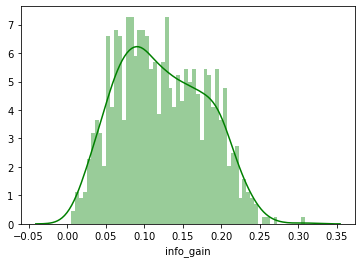

In [12]:
info_gain = pd.DataFrame(info_gain, index = [0]).T
info_gain.columns = ["info_gain"]
sns.distplot(info_gain["info_gain"], bins = 60, color = "green")

In [13]:
info_gain = info_gain.reset_index()
info_gain.columns = ["feat_names", "info_gain"]

In [14]:
selected_feat = info_gain[info_gain["info_gain"] > 0.06]["feat_names"].to_list()
selected_feat.extend(['sig_id', 'cp_type', 'cp_time', 'cp_dose'])

In [15]:
train_features = train_features[selected_feat]
test_features = test_features[selected_feat]

In [16]:
cols_numeric = [feat for feat in list(train_features.columns) if feat not in ['sig_id', 'cp_type', 'cp_time', 'cp_dose']]

In [17]:
train_features

g-0     g-3     g-4     g-7     g-8     g-9    g-10    g-11    g-12  \
0      1.0620 -0.6208 -0.1944 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574   
1      0.0743  0.0604  1.0190  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958   
2      0.6280 -0.0764 -0.0323  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366   
3     -0.5138  0.5288  4.0620  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511   
4     -0.3254  0.6919  1.4180 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
21943  0.1608 -0.2239 -0.2431 -0.1777 -0.7480  0.1368  0.5493 -0.5083  0.4112   
21944  0.1394 -0.5080 -0.4713  0.3055 -0.4726  0.1269  0.2531  0.1730 -0.4532   
21945 -1.3260  0.9905 -0.7178 -0.5565  0.5112  0.6727 -0.1851  2.8650 -0.2140   
21946  0.6660  0.2044  0.8531  0.0463  0.4299 -0.7985  0.5742  0.1421  2.2700   
21947 -0.8598  0.7952 -0.3611  0.9146  3.0790  1.2460  1.9460  1.4370  2.9780   

         g-13  ...    c-94    c-95    c-96    c-97    c-98    c-99  \
0     -0.4015  ... -0.1912  0.6584 -0.3981  0.2139  0.3801  0.4176   
1      0.4590  ...  0.2957  0.4899  0.1522  0.1241  0.6077  0.7371   
2     -1.8300  ... -1.3240 -0.3174 -0.6417 -0.2187 -1.4080  0.6931   
3     -0.5844  ... -0.8632 -1.2880 -1.6210 -0.8784 -0.3876 -0.8154   
4      1.1750  ...  0.5523 -0.3031  0.1094  0.2885 -0.3786  0.7125   
...       ...  ...     ...     ...     ...     ...     ...     ...   
21943  0.1181  ... -0.4753 -0.2504 -0.7415  0.8413 -0.4259  0.2434   
21944 -1.0790  ...  0.5372 -0.3246  0.0631  0.9171  0.5258  0.4680   
21945 -0.6153  ... -0.8086 -0.9798 -0.2084 -0.1224 -0.2715  0.3689   
21946  0.2046  ...  1.5230  0.7101  0.1732  0.7015 -0.6290  0.0740   
21947  2.2370  ... -7.3860 -1.4160 -3.5770 -0.4775 -2.1500 -4.2520   

             sig_id  cp_type  cp_time  cp_dose  
0      id_000644bb2   trt_cp       24       D1  
1      id_000779bfc   trt_cp       72       D1  
2      id_000a6266a   trt_cp       48       D1  
3      id_0015fd391   trt_cp       48       D1  
4      id_001626bd3   trt_cp       72       D2  
...             ...      ...      ...      ...  
21943  id_fff8c2444   trt_cp       72       D1  
21944  id_fffb1ceed   trt_cp       24       D2  
21945  id_fffb70c0c   trt_cp       24       D2  
21946  id_fffcb9e7c   trt_cp       24       D1  
21947  id_ffffdd77b   trt_cp       72       D1  

[21948 rows x 752 columns]

## 2.3 PCA

In [18]:
# We are actully adding the feature from the pca into the original data in here, it helps the score for some reason
def pca(train, test, n_comp = 55, type_ = "", SEED = 123):
    
    kind = "g" if type_ == GENES else "c"
    data = pd.concat([train[type_], test[type_]])
    pca = PCA(n_components= n_comp)
    data = pd.DataFrame(pca.fit_transform(data), columns = [f'pca_{kind}{i + 1}' for i in range(n_comp)])
    train_ = data.iloc[:train.shape[0]]
    test_ = data.iloc[train.shape[0]:].reset_index(drop = True)
    train = pd.concat([train, train_], axis = 1)
    test = pd.concat([test, test_], axis = 1)
    return train, test

In [19]:
#All the col that has genes and cells
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

In [20]:
train_features, test_features = pca(train_features, test_features, n_comp = 60, type_ = GENES)
train_features, test_features = pca(train_features, test_features, n_comp = 20, type_ = CELLS)

## 2.5 Gauss Rank Scaler

In [21]:
cols_numeric = [feat for feat in list(train_features.columns) if feat not in ['sig_id', 'cp_type', 'cp_time', 'cp_dose']]

In [22]:
data = pd.concat([train_features, test_features], ignore_index = True)

In [23]:
#Normalize the data
scaler = GaussRankScaler()
data[cols_numeric]  = scaler.fit_transform(data[cols_numeric])

## 2.6 Number of Positive and Negative Values

In [24]:
def num_pos_num_neg(data, type_):
    kind = "g" if type_ == GENES else "c"
    train_ = data.iloc[:train_features.shape[0]].reset_index(drop = True)
    test_ = data.iloc[train_features.shape[0]:].reset_index(drop = True)
    for df in [train_, test_]:
        df[f'{kind}_positive'] = df[type_].select_dtypes(include='float64').gt(0).sum(axis=1)
        df[f'{kind}_negative'] = df[type_].select_dtypes(include='float64').lt(0).sum(axis=1)
    return pd.concat([train_, test_], ignore_index = True)

In [25]:
# data = num_pos_num_neg(data, GENES)
# data = num_pos_num_neg(data, CELLS)

In [26]:
data

g-0       g-3       g-4       g-7       g-8       g-9      g-10  \
0      0.731433 -0.615315 -0.194236  0.005623  0.513989 -0.130963  1.094414   
1      0.017020  0.027107  0.849834  0.363904 -0.298420  0.730029 -0.808914   
2      0.462792 -0.091777 -0.039121  0.242395  0.050070  0.975415 -0.385579   
3     -0.531916  0.455184  1.595325  0.206249 -0.066407 -0.889590 -0.656089   
4     -0.341668  0.604615  0.951946 -0.103294 -0.684346  0.741863 -0.175749   
...         ...       ...       ...       ...       ...       ...       ...   
25567  0.332498 -0.614731  0.734282 -0.505731 -0.815152  0.607761  0.248689   
25568 -0.611355  0.285795  0.386483  0.023174  0.260311  1.252813  0.182971   
25569 -0.413779 -0.680627  0.003715  0.823115  0.072491  1.027777  0.419733   
25570 -1.215509  0.892980 -1.179341 -0.844475  0.937721  0.552455  1.232116   
25571 -0.535701 -0.062814 -0.082960  0.417050  0.005587  0.246355  0.214542   

           g-11      g-12      g-13  ...   pca_c11   pca_c12   pca_c13  \
0      0.089109  0.438805 -0.398784  ...  0.510728 -0.358790 -0.664748   
1     -0.402677 -0.110287  0.333450  ...  0.790459 -0.245896  0.775866   
2     -0.540332 -0.061461 -1.514045  ... -0.407775 -0.030715  0.490157   
3     -0.347110 -0.771050 -0.580286  ...  0.219267 -0.232902  0.800115   
4     -0.491503 -0.865195  0.786547  ...  0.059066 -0.500958  0.283080   
...         ...       ...       ...  ...       ...       ...       ...   
25567  0.657995  0.617570 -0.689327  ...  0.367103  0.358721 -1.140657   
25568  0.283988  0.705622 -1.049138  ...  0.279104  0.500434  0.544240   
25569 -0.410056 -0.129953 -0.281797  ... -0.247738  0.860177  0.275511   
25570  0.507866  0.865186  0.835581  ... -0.127191 -0.068036  0.025104   
25571  0.163374 -0.151556  0.859550  ...  0.541262 -0.209967 -0.404342   

        pca_c14   pca_c15   pca_c16   pca_c17   pca_c18   pca_c19   pca_c20  
0      0.170439  0.417648 -1.248147  1.057254  0.799326  0.338524 -0.231585  
1      0.097851  1.176227 -0.091898 -0.944473  0.301049 -0.174501 -0.354146  
2      0.309419 -0.037031  1.033478  0.205850  0.987307  0.424269 -0.572252  
3     -1.241293  1.244906  0.862069 -1.185702 -0.673316 -0.668749  0.484881  
4     -0.198548 -0.419786  0.804734  0.052181 -0.244644 -0.607698  0.298622  
...         ...       ...       ...       ...       ...       ...       ...  
25567 -0.952999 -0.371066 -0.264021  0.918896  0.054267 -0.103376 -0.399535  
25568  0.636289 -0.421027  0.173438 -0.076329 -0.067967 -0.547872 -0.238838  
25569 -0.723795  0.213093 -0.329293  0.027324  0.472416 -0.007552 -0.057875  
25570  0.149387  0.239948 -0.012613  0.571590 -0.074446  0.209324  0.112712  
25571 -0.295206  0.123819 -0.063511  0.826715 -0.376886  0.519041 -0.891355  

[25572 rows x 832 columns]

## 2.7 Stats of Features

In [27]:
#All the col that has genes and cells
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

In [28]:
for stats in tqdm.tqdm(["mean", "std", "kurt", "skew"]):
    data["g_" + stats] = getattr(data[GENES], stats)(axis = 1)
    data["c_" + stats] = getattr(data[CELLS], stats)(axis = 1)    
#     data["gc_" + stats] = getattr(data[GENES + CELLS], stats)(axis = 1)

100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


In [29]:
def multiply_feat(df):
    df['c52_c42'] = df['c-52'] * df['c-42']
    df['c13_c73'] = df['c-13'] * df['c-73']
    df['c26_c13'] = df['c-23'] * df['c-13']
    df['c33_c6'] = df['c-33'] * df['c-6']
    df['c11_c55'] = df['c-11'] * df['c-55']
#     df['c38_c63'] = df['c-38'] * df['c-63']
#     df['c38_c94'] = df['c-38'] * df['c-94']
#     df['c13_c94'] = df['c-13'] * df['c-94']
#     df['c4_c52'] = df['c-4'] * df['c-52']
#     df['c4_c42'] = df['c-4'] * df['c-42']
#     df['c13_c38'] = df['c-13'] * df['c-38']
#     df['c55_c2'] = df['c-55'] * df['c-2']
#     df['c55_c4'] = df['c-55'] * df['c-4']
#     df['c4_c13'] = df['c-4'] * df['c-13']
#     df['c82_c42'] = df['c-82'] * df['c-42']
#     df['c66_c42'] = df['c-66'] * df['c-42']
#     df['c6_c38'] = df['c-6'] * df['c-38']
#     df['c2_c13'] = df['c-2'] * df['c-13']
#     df['c62_c42'] = df['c-62'] * df['c-42']
#     df['c90_c55'] = df['c-90'] * df['c-55']
    
    return df

In [30]:
# data = multiply_feat(data)

In [31]:
#Spliting the data back into train and test
train_features = data.iloc[:train_features.shape[0]].reset_index(drop = True)
test_features = data.iloc[train_features.shape[0]:].reset_index(drop = True)

# 3. Preprocessing

## 3.1 Get Dummies & Dropping sig_id

In [32]:
def preprocess(data, target=False):
    data.drop("sig_id", axis=1, inplace=True)
    if target == False:
        data["cp_dose_time"] = data["cp_dose"] + "_" + data["cp_time"].astype("str")
        data["cp_time"] = data["cp_time"].map({24:0, 48:1, 72:2})
    return data

In [33]:
train_features = preprocess(train_features)
train_targets = preprocess(train_targets, target=True)
train_features = pd.get_dummies(train_features)
test_features = preprocess(test_features)
test_features = pd.get_dummies(test_features)

In [34]:
train_features

g-0       g-3       g-4       g-7       g-8       g-9      g-10  \
0      0.731433 -0.615315 -0.194236  0.005623  0.513989 -0.130963  1.094414   
1      0.017020  0.027107  0.849834  0.363904 -0.298420  0.730029 -0.808914   
2      0.462792 -0.091777 -0.039121  0.242395  0.050070  0.975415 -0.385579   
3     -0.531916  0.455184  1.595325  0.206249 -0.066407 -0.889590 -0.656089   
4     -0.341668  0.604615  0.951946 -0.103294 -0.684346  0.741863 -0.175749   
...         ...       ...       ...       ...       ...       ...       ...   
21943  0.089366 -0.226762 -0.244678 -0.130161 -0.582338  0.056587  0.510729   
21944  0.072056 -0.499092 -0.479222  0.333563 -0.356318  0.048109  0.229485   
21945 -1.346695  0.878667 -0.735139 -0.446960  0.479298  0.549999 -0.144491   
21946  0.490027  0.157679  0.732402  0.079245  0.405150 -0.742506  0.534247   
21947 -0.939748  0.695101 -0.365699  1.045868  1.472960  0.980444  1.376366   

           g-11      g-12      g-13  ...    c_skew  cp_type_trt_cp  \
0      0.089109  0.438805 -0.398784  ...  0.118667               1   
1     -0.402677 -0.110287  0.333450  ... -0.043717               1   
2     -0.540332 -0.061461 -1.514045  ...  0.379548               1   
3     -0.347110 -0.771050 -0.580286  ...  2.010409               1   
4     -0.491503 -0.865195  0.786547  ...  0.191181               1   
...         ...       ...       ...  ...       ...             ...   
21943 -0.487753  0.312606  0.055267  ...  0.473883               1   
21944  0.104717 -0.417681 -1.131700  ...  0.367298               1   
21945  1.105080 -0.209672 -0.614014  ...  0.484219               1   
21946  0.080075  1.093433  0.127083  ...  0.200423               1   
21947  0.826468  1.224178  0.993635  ...  1.850527               1   

       cp_dose_D1  cp_dose_D2  cp_dose_time_D1_24  cp_dose_time_D1_48  \
0               1           0                   1                   0   
1               1           0                   0                   0   
2               1           0                   0                   1   
3               1           0                   0                   1   
4               0           1                   0                   0   
...           ...         ...                 ...                 ...   
21943           1           0                   0                   0   
21944           0           1                   0                   0   
21945           0           1                   0                   0   
21946           1           0                   1                   0   
21947           1           0                   0                   0   

       cp_dose_time_D1_72  cp_dose_time_D2_24  cp_dose_time_D2_48  \
0                       0                   0                   0   
1                       1                   0                   0   
2                       0                   0                   0   
3                       0                   0                   0   
4                       0                   0                   0   
...                   ...                 ...                 ...   
21943                   1                   0                   0   
21944                   0                   1                   0   
21945                   0                   1                   0   
21946                   0                   0                   0   
21947                   1                   0                   0   

       cp_dose_time_D2_72  
0                       0  
1                       0  
2                       0  
3                       0  
4                       1  
...                   ...  
21943                   0  
21944                   0  
21945                   0  
21946                   0  
21947                   0  

[21948 rows x 846 columns]

## 3.2 Define Error/Loss Metric and Prediction clipping

In [35]:
def multi_log_loss(y_true, y_pred):
    losses = []
    for col in y_true.columns:
        losses.append(log_loss(y_true.loc[:, col], y_pred.loc[:, col]))
    return np.mean(losses)

In [36]:
def clip(y_pred, c_min, c_max):
    return np.clip(y_pred, c_min, c_max)

In [37]:
p_min = 0.001
p_max = 0.999

# 4. Create Model and Perform KFold

### 4.1.1 Two Layer DNN

In [38]:
#The model param is tuned with optuna 
#The leaky ReLu performs the best
def create_model_v1(shape):
    model = M.Sequential()
    model.add(L.Input(shape = (shape)))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.397816152960733))
    model.add(tfa.layers.WeightNormalization(L.Dense(521)))
    model.add(L.LeakyReLU(alpha = 0.10059420295821832))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.4365714774136811))
    model.add(tfa.layers.WeightNormalization(L.Dense(1634)))
    model.add(L.LeakyReLU(alpha = 0.10059420295821832))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.4365714774136811))
    model.add(tfa.layers.WeightNormalization(L.Dense(206, activation = "sigmoid")))
    model.compile(optimizer=tfa.optimizers.AdamW(lr = 2e-3, weight_decay = 1e-5, clipvalue = 756), 
                  loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.001),
                  metrics=tf.keras.metrics.BinaryCrossentropy())
    return model

### 4.1.2 Training Function

In [39]:
def train_ann(seed, fold, train_features, train_targets, train_ind, val_ind, shape):

    model = create_model_v1(shape)
    
            
    print('\n')
    print('-'*50)
    print(f'Training fold {fold + 1}')

    checkpoint_path = f'repeat:{seed}_Fold:{fold}.hdf5'
    cb_checkpt = C.ModelCheckpoint(checkpoint_path, monitor = 'val_binary_crossentropy', verbose = 2, save_best_only = True, save_weights_only = True, mode = 'auto')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_binary_crossentropy',
                                                    mode = 'min',
                                                    factor = 0.2,
                                                    patience = 3,
                                                     
                                                     
                                                    verbose = 3)
    early = tf.keras.callbacks.EarlyStopping(monitor = 'val_binary_crossentropy',
                                            mode = 'min',
                                            patience = 10,
                                            restore_best_weights = True,
                                            verbose = 3)
    model.fit(train_features.values[train_ind],
            train_targets.values[train_ind], validation_data=(train_features.values[val_ind], train_targets.values[val_ind]),
            epochs=200, batch_size=96, verbose=2, callbacks = [reduce_lr, early, cb_checkpt])
    
    model.load_weights(checkpoint_path)
    
    return model

## 4.2 TabNet

### 4.2.1 AdaBelief Optimizer

In [40]:
version_higher = ( torch.__version__ >= "1.5.0" )

class AdaBelief(Optimizer):
    r"""Implements AdaBelief algorithm. Modified from Adam in PyTorch
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
        weight_decouple (boolean, optional): ( default: False) If set as True, then
            the optimizer uses decoupled weight decay as in AdamW
        fixed_decay (boolean, optional): (default: False) This is used when weight_decouple
            is set as True.
            When fixed_decay == True, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay$.
            When fixed_decay == False, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay \times lr$. Note that in this case, the
            weight decay ratio decreases with learning rate (lr).
        rectify (boolean, optional): (default: False) If set as True, then perform the rectified
            update similar to RAdam
    reference: AdaBelief Optimizer, adapting stepsizes by the belief in observed gradients
               NeurIPS 2020 Spotlight
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False, weight_decouple = False, fixed_decay=False, rectify = False ):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(AdaBelief, self).__init__(params, defaults)

        self.weight_decouple = weight_decouple
        self.rectify = rectify
        self.fixed_decay = fixed_decay
        if self.weight_decouple:
            print('Weight decoupling enabled in AdaBelief')
            if self.fixed_decay:
                print('Weight decay fixed')
        if self.rectify:
            print('Rectification enabled in AdaBelief')
        if amsgrad:
            print('AMS enabled in AdaBelief')
    def __setstate__(self, state):
        super(AdaBelief, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def reset(self):
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                amsgrad = group['amsgrad']

                # State initialization
                state['step'] = 0
                # Exponential moving average of gradient values
                state['exp_avg'] = torch.zeros_like(p.data,
                                   memory_format=torch.preserve_format) if version_higher else torch.zeros_like(p.data)

                # Exponential moving average of squared gradient values
                state['exp_avg_var'] = torch.zeros_like(p.data,
                                    memory_format=torch.preserve_format) if version_higher else torch.zeros_like(p.data)
                if amsgrad:
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state['max_exp_avg_var'] = torch.zeros_like(p.data,
                                    memory_format=torch.preserve_format) if version_higher else torch.zeros_like(p.data)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('AdaBelief does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]
               
                beta1, beta2 = group['betas']

                # State initialization
                if len(state) == 0:
                    state['rho_inf'] = 2.0 / (1.0 - beta2) - 1.0
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data,
                                    memory_format=torch.preserve_format) if version_higher else torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_var'] = torch.zeros_like(p.data,
                                    memory_format=torch.preserve_format) if version_higher else torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_var'] = torch.zeros_like(p.data,
                                    memory_format=torch.preserve_format) if version_higher else torch.zeros_like(p.data)

                # get current state variable
                exp_avg, exp_avg_var = state['exp_avg'], state['exp_avg_var']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # perform weight decay, check if decoupled weight decay
                if self.weight_decouple:
                    if not self.fixed_decay:
                        p.data.mul_(1.0 - group['lr'] * group['weight_decay'])
                    else:
                        p.data.mul_(1.0 - group['weight_decay'])
                else:
                    if group['weight_decay'] != 0:
                        grad.add_(group['weight_decay'], p.data)

                # Update first and second moment running average
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                grad_residual = grad - exp_avg
                exp_avg_var.mul_(beta2).addcmul_(1 - beta2, grad_residual, grad_residual)

                if amsgrad:
                    max_exp_avg_var = state['max_exp_avg_var']
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_var, exp_avg_var, out=max_exp_avg_var)

                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_var.add_(group['eps']).sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_var.add_(group['eps']).sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

                if not self.rectify:
                    # Default update
                    step_size = group['lr'] / bias_correction1
                    p.data.addcdiv_(-step_size, exp_avg, denom)

                else:# Rectified update
                    # calculate rho_t
                    state['rho_t'] = state['rho_inf'] - 2 * state['step'] * beta2 ** state['step'] / (
                            1.0 - beta2 ** state['step'])

                    if state['rho_t'] > 4: # perform Adam style update if variance is small
                        rho_inf, rho_t = state['rho_inf'], state['rho_t']
                        rt = (rho_t - 4.0) * (rho_t - 2.0) * rho_inf / (rho_inf - 4.0) / (rho_inf - 2.0) / rho_t
                        rt = math.sqrt(rt)

                        step_size = rt * group['lr'] / bias_correction1

                        p.data.addcdiv_(-step_size, exp_avg, denom)

                    else: # perform SGD style update
                        p.data.add_( -group['lr'], exp_avg)

        return loss

### 4.2.2 Custom Loss for TabNet

In [41]:
class LogitsLogLoss(Metric):
    """
    LogLoss with sigmoid applied
    """

    def __init__(self):
        self._name = "logits_ll"
        self._maximize = False

    def __call__(self, y_true, y_pred):
        """
        Compute LogLoss of predictions.

        Parameters
        ----------
        y_true: np.ndarray
            Target matrix or vector
        y_score: np.ndarray
            Score matrix or vector

        Returns
        -------
            float
            LogLoss of predictions vs targets.
        """
        logits = 1 / (1 + np.exp(-y_pred))
        aux = (1 - y_true) * np.log(1 - logits + 1e-15) + y_true * np.log(logits + 1e-15)
        return np.mean(-aux)

### 4.2.3 Training Function

In [42]:
def train_tabnet(seed, fold, train_features, train_targets, train_ind, val_ind):
    model = TabNetRegressor(**tabnet_params)

    print('\n')
    print('-'*50)
    print(f'Training fold {fold + 1}')
                
                
    model.fit(X_train = train_features.values[train_ind], y_train = train_targets.values[train_ind], eval_set = [(train_features.values[val_ind], train_targets.values[val_ind])], 
            eval_name = ["val"], eval_metric = ["logits_ll"], max_epochs = MAX_EPOCH,
            patience = 20, batch_size = 256, virtual_batch_size = 32, num_workers = 4, drop_last = False,
#               from_unsupervised=pretrainer,
            # To use binary cross entropy because this is not a regression problem
            loss_fn = F.binary_cross_entropy_with_logits
            )
    
    return model

### 4.2.5 Model Params

In [43]:
MAX_EPOCH = 200
tabnet_params = dict(
    n_d = 64,
    n_a = 32,
    n_steps = 1,
    gamma = 1.3,
    momentum = 0.05,
    n_independent = 1,
    n_shared = 1,
    lambda_sparse = 0,
    optimizer_fn = AdaBelief,
    optimizer_params = dict(lr = 6e-3, weight_decay = 1e-5, eps=1e-15),
    mask_type = "entmax",
    scheduler_params = dict(
        mode = "min", patience = 4, min_lr = 7e-6, factor = 0.25),
    scheduler_fn = ReduceLROnPlateau,
    seed = 1,
    verbose = 10
)

In [44]:
# from pytorch_tabnet.pretraining import TabNetPretrainer

# BS=512
# MAX_EPOCH=75

# pretrainer = TabNetPretrainer(**tabnet_params)

# pretrainer.fit(X_train=train_features.values, #  np.vstack([train.values[:,1:], test.values[:,1:]])
#           max_epochs=MAX_EPOCH,
#           patience=20, batch_size=BS, virtual_batch_size=128, #128,
#           num_workers=0, drop_last=True,
#           pretraining_ratio=0.6)

## 4.3 KFold

In [45]:
def make_folds(folds):
    models = []
    predictions = []
    
    for i in range(3):
        
        seed = i
        seed_everything(seed)
        
        model_list = list()
        kfold = MultilabelStratifiedKFold(folds, shuffle = True, random_state = seed)
        oof_preds = train_targets.copy()
        
        print(f"REAPEAT NUMBER {i + 1} SEED {seed}")
        
        for fold, (train_ind, val_ind) in enumerate(kfold.split(train_features, train_targets)):
            
            if i > 0:
                print("TabNet")
                model = train_tabnet(seed, fold, train_features, train_targets, train_ind, val_ind)
                model_list.append(model)
                preds = model.predict(train_features.values[val_ind])
                preds = 1 / (1 + np.exp(-preds))
                oof_preds.iloc[val_ind, :] = clip(preds, p_min, p_max)
            
            if i == 0:
                print("ANN")
                model = train_ann(seed, fold, train_features, train_targets, train_ind, val_ind, 846)
                model_list.append(model)
                oof_preds.iloc[val_ind, :] = clip(model.predict(train_features.values[val_ind]), p_min, p_max)

        m, oof = model_list, oof_preds
        models = models + m
        
        predictions.append(oof)
    return models, predictions

In [46]:
models, oof_preds = make_folds(10)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


REAPEAT NUMBER 1 SEED 0
ANN


--------------------------------------------------
Training fold 1
Epoch 1/200

Epoch 00001: val_binary_crossentropy improved from inf to 0.02137, saving model to repeat:0_Fold:0.hdf5
206/206 - 2s - loss: 0.1652 - binary_crossentropy: 0.1636 - val_loss: 0.0240 - val_binary_crossentropy: 0.0214
Epoch 2/200

Epoch 00002: val_binary_crossentropy improved from 0.02137 to 0.01876, saving model to repeat:0_Fold:0.hdf5
206/206 - 2s - loss: 0.0238 - binary_crossentropy: 0.0210 - val_loss: 0.0218 - val_binary_crossentropy: 0.0188
Epoch 3/200

Epoch 00003: val_binary_crossentropy improved from 0.01876 to 0.01779, saving model to repeat:0_Fold:0.hdf5
206/206 - 2s - loss: 0.0223 - binary_crossentropy: 0.0192 - val_loss: 0.0209 - val_binary_crossentropy: 0.0178
Epoch 4/200

Epoch 00004: val_binary_crossentropy improved from 0.01779 to 0.01745, saving model to repeat:0_Fold:0.hdf5
206/206 - 2s - loss: 0.0216 - binary_crossentropy: 0.0184 - val_loss: 0.0206 - val_binary_

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


REAPEAT NUMBER 2 SEED 1
TabNet
Device used : cuda


--------------------------------------------------
Training fold 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:135: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)


epoch 0  | loss: 0.15344 | val_logits_ll: 0.02226 |  0:00:03s
epoch 10 | loss: 0.01743 | val_logits_ll: 0.0176  |  0:00:35s
epoch 20 | loss: 0.01667 | val_logits_ll: 0.01706 |  0:01:06s
epoch 30 | loss: 0.01621 | val_logits_ll: 0.01687 |  0:01:38s
epoch 40 | loss: 0.01469 | val_logits_ll: 0.0161  |  0:02:10s
epoch 50 | loss: 0.01296 | val_logits_ll: 0.01656 |  0:02:41s
epoch 60 | loss: 0.01232 | val_logits_ll: 0.01676 |  0:03:11s

Early stopping occured at epoch 60 with best_epoch = 40 and best_val_logits_ll = 0.0161
Best weights from best epoch are automatically used!
TabNet
Device used : cuda


--------------------------------------------------
Training fold 2
epoch 0  | loss: 0.15379 | val_logits_ll: 0.02231 |  0:00:03s
epoch 10 | loss: 0.0176  | val_logits_ll: 0.01753 |  0:00:34s
epoch 20 | loss: 0.01659 | val_logits_ll: 0.01666 |  0:01:05s
epoch 30 | loss: 0.01492 | val_logits_ll: 0.01622 |  0:01:36s
epoch 40 | loss: 0.01316 | val_logits_ll: 0.01644 |  0:02:07s
epoch 50 | loss: 0.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


REAPEAT NUMBER 3 SEED 2
TabNet
Device used : cuda


--------------------------------------------------
Training fold 1
epoch 0  | loss: 0.15392 | val_logits_ll: 0.0225  |  0:00:03s
epoch 10 | loss: 0.01752 | val_logits_ll: 0.01772 |  0:00:34s
epoch 20 | loss: 0.01667 | val_logits_ll: 0.01677 |  0:01:06s
epoch 30 | loss: 0.01519 | val_logits_ll: 0.01606 |  0:01:36s
epoch 40 | loss: 0.01335 | val_logits_ll: 0.01632 |  0:02:08s
epoch 50 | loss: 0.01254 | val_logits_ll: 0.01655 |  0:02:40s

Early stopping occured at epoch 51 with best_epoch = 31 and best_val_logits_ll = 0.01599
Best weights from best epoch are automatically used!
TabNet
Device used : cuda


--------------------------------------------------
Training fold 2
epoch 0  | loss: 0.15323 | val_logits_ll: 0.02216 |  0:00:02s
epoch 10 | loss: 0.01745 | val_logits_ll: 0.01766 |  0:00:34s
epoch 20 | loss: 0.0166  | val_logits_ll: 0.01733 |  0:01:05s
epoch 30 | loss: 0.01621 | val_logits_ll: 0.01688 |  0:01:36s
epoch 40 | loss: 0.0159

In [47]:
mean_oof_preds = train_targets.copy()
mean_oof_preds.loc[:, target_cols] = 0
scores = []
for i, p in enumerate(oof_preds):
    loss = multi_log_loss(train_targets, p)
    print(f"Repeat {i + 1} OOF Log Loss: {loss}")
    scores.append(loss)
    mean_oof_preds.loc[:,target_cols] += p
mean_oof_preds.loc[:, target_cols] /= len(oof_preds)
print(f"Mean OOF Log Loss: {multi_log_loss(train_targets, mean_oof_preds)}")

Repeat 1 OOF Log Loss: 0.01585272294425286
Repeat 2 OOF Log Loss: 0.016394556938144025
Repeat 3 OOF Log Loss: 0.01635482369218773
Mean OOF Log Loss: 0.015753509530521195


## 4.4 Export Predictions For Optimizing Blending Weights

In [48]:
for i, p in enumerate(oof_preds):
    p.to_csv(f"pred_{i}.csv", index = False)

## 4.5 Bleding Using Weighted Average

In [49]:
oof = np.zeros((len(oof_preds), train_targets.shape[0], train_targets.shape[1]))

In [50]:
for i in range(len(oof_preds)):
    oof[i] = oof_preds[i]

In [51]:
def blend_preds(weights):
    oof_blend = np.tensordot(weights, oof, axes = ((0), (0)))
    return oof_blend

In [52]:
def log_loss_numpy(y_pred):
    y_true_ravel = np.asarray(train_targets).ravel()
    y_pred = np.asarray(y_pred).ravel()
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    loss = np.where(y_true_ravel == 1, - np.log(y_pred), - np.log(1 - y_pred))
    return loss.mean()

In [53]:
oof_blend = blend_preds([0.26, 0.39, 0.35])
print(f"Optimized Blend Loss: {log_loss_numpy(oof_blend)}")

Optimized Blend Loss: 0.01579669752677265


# 5. Submission File

In [54]:
test_ = pd.read_csv('../input/lish-moa/test_features.csv')
sig_id = test_[test_["cp_type"] != "ctl_vehicle"].sig_id.reset_index(drop = True)
test_preds = sub.copy()
test_preds[target_cols] = 0
test_preds = test_preds.drop("sig_id", axis = 1)
test_preds["sig_id"] = sig_id
test_preds.dropna(inplace=True)
test_preds.drop("sig_id", axis = 1, inplace=True)

In [55]:
oof = np.zeros((len(oof_preds), test_preds.shape[0], test_preds.shape[1]))

In [56]:
test_pred1 = test_preds.copy()
test_pred2 = test_preds.copy()
test_pred3 = test_preds.copy()

In [57]:
for i, model in enumerate(models):
    if (i + 1) <= 10:
        preds = model.predict(test_features.values)
        test_pred1.loc[:,target_cols] += clip(preds, p_min, p_max)
    if (i + 1) <= 20 and (i + 1) > 10:
        preds = model.predict(test_features.values)
        preds = 1 / (1 + np.exp(-preds))
        test_pred2.loc[:,target_cols] += clip(preds, p_min, p_max)
    if (i + 1) > 20:
        preds = model.predict(test_features.values)
        preds = 1 / (1 + np.exp(-preds))
        test_pred3.loc[:,target_cols] += clip(preds, p_min, p_max)

In [58]:
test_pred1.loc[:, target_cols] /= 10
test_pred2.loc[:, target_cols] /= 10
test_pred3.loc[:, target_cols] /= 10

In [59]:
oof_preds = [test_pred1, test_pred2, test_pred3]

for i in range(len(oof_preds)):
    oof[i] = oof_preds[i]
    
test_blend_preds = blend_preds([0.26, 0.39, 0.35])

In [60]:
test_preds[target_cols] = test_blend_preds

In [61]:
test_preds["sig_id"] = sig_id
test_features = pd.read_csv('../input/lish-moa/test_features.csv')
submission = pd.merge(test_features[["sig_id"]], test_preds, on = "sig_id", how = "left")
submission.fillna(0, inplace = True)
sub = submission.to_csv('submission.csv', index=False)

In [62]:
submission

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0     id_0004d9e33                     0.001155                0.001297   
1     id_001897cda                     0.001000                0.001098   
2     id_002429b5b                     0.000000                0.000000   
3     id_00276f245                     0.001026                0.001035   
4     id_0027f1083                     0.001433                0.001858   
...            ...                          ...                     ...   
3977  id_ff7004b87                     0.001027                0.001302   
3978  id_ff925dd0d                     0.002918                0.002433   
3979  id_ffb710450                     0.001668                0.001298   
3980  id_ffbb869f2                     0.001329                0.001304   
3981  id_ffd5800b6                     0.001118                0.001197   

      acat_inhibitor  acetylcholine_receptor_agonist  \
0           0.002330                        0.015206   
1           0.001935                        0.002532   
2           0.000000                        0.000000   
3           0.001715                        0.013131   
4           0.001794                        0.018297   
...              ...                             ...   
3977        0.001287                        0.003127   
3978        0.001484                        0.008940   
3979        0.001160                        0.013833   
3980        0.001201                        0.025012   
3981        0.001675                        0.017771   

      acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                              0.017180                        0.004809   
1                              0.002347                        0.002031   
2                              0.000000                        0.000000   
3                              0.012946                        0.005428   
4                              0.024744                        0.004441   
...                                 ...                             ...   
3977                           0.007432                        0.002429   
3978                           0.018561                        0.004863   
3979                           0.047847                        0.006083   
3980                           0.023658                        0.006315   
3981                           0.021451                        0.006345   

      adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                       0.002277                       0.006463   
1                       0.002773                       0.008872   
2                       0.000000                       0.000000   
3                       0.002843                       0.003284   
4                       0.004645                       0.002538   
...                          ...                            ...   
3977                    0.001647                       0.002708   
3978                    0.003738                       0.003348   
3979                    0.003079                       0.004218   
3980                    0.004800                       0.003115   
3981                    0.003564                       0.005365   

      adenylyl_cyclase_activator  ...  tropomyosin_receptor_kinase_inhibitor  \
0                       0.001000  ...                               0.001152   
1                       0.002745  ...                               0.001048   
2                       0.000000  ...                               0.000000   
3                       0.001000  ...                               0.001000   
4                       0.001000  ...                               0.001180   
...                          ...  ...                                    ...   
3977                    0.001036  ...                               0.001007   
3978                    0.001012  ...                               0.001000   
3979        

In [63]:
test_preds

5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  acat_inhibitor  \
0                        0.001155                0.001297        0.002330   
1                        0.001000                0.001098        0.001935   
2                        0.001026                0.001035        0.001715   
3                        0.001433                0.001858        0.001794   
4                        0.001040                0.001056        0.001959   
...                           ...                     ...             ...   
3619                     0.001027                0.001302        0.001287   
3620                     0.002918                0.002433        0.001484   
3621                     0.001668                0.001298        0.001160   
3622                     0.001329                0.001304        0.001201   
3623                     0.001118                0.001197        0.001675   

      acetylcholine_receptor_agonist  acetylcholine_receptor_antagonist  \
0                           0.015206                           0.017180   
1                           0.002532                           0.002347   
2                           0.013131                           0.012946   
3                           0.018297                           0.024744   
4                           0.025927                           0.022872   
...                              ...                                ...   
3619                        0.003127                           0.007432   
3620                        0.008940                           0.018561   
3621                        0.013833                           0.047847   
3622                        0.025012                           0.023658   
3623                        0.017771                           0.021451   

      acetylcholinesterase_inhibitor  adenosine_receptor_agonist  \
0                           0.004809                    0.002277   
1                           0.002031                    0.002773   
2                           0.005428                    0.002843   
3                           0.004441                    0.004645   
4                           0.004958                    0.005107   
...                              ...                         ...   
3619                        0.002429                    0.001647   
3620                        0.004863                    0.003738   
3621                        0.006083                    0.003079   
3622                        0.006315                    0.004800   
3623                        0.006345                    0.003564   

      adenosine_receptor_antagonist  adenylyl_cyclase_activator  \
0                          0.006463                    0.001000   
1                          0.008872                    0.002745   
2                          0.003284                    0.001000   
3                          0.002538                    0.001000   
4                          0.002404                    0.001015   
...                             ...                         ...   
3619                       0.002708                    0.001036   
3620                       0.003348                    0.001012   
3621                       0.004218                    0.001000   
3622                       0.003115                    0.001122   
3623                       0.005365                    0.001000   

      adrenergic_receptor_agonist  ...  trpv_agonist  trpv_antagonist  \
0                        0.009842  ...      0.001675         0.003923   
1                        0.008051  ...      0.001226         0.004098   
2                        0.010716  ...      0.001843         0.002613   
3                        0.010131  ...      0.001084         0.003385   
4                        0.013770  ...      0.001119         0.003209   
...                           ...  ...           ...              ...   
3619                     0.003464  ...      0.0

In [64]:
def Diff(list1, list2): 
    return (list(list(set(list1)-set(list2)) + list(set(list2)-set(list1)))) 

Diff (submission.columns, pd.read_csv('../input/lish-moa/sample_submission.csv').columns)

[]